In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
print(__doc__)

import numpy as np
from matplotlib import pyplot as plt

from crawlab_toolbox import plotting

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
assert tf.__version__ >= "2.0"

from ML_Train.Vanilla_AE import create_vanilla_ae
from ML_Train.Convolutional_AE import create_autoencoder as create_cnn_ae

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)


Automatically created module for IPython interactive environment


Using TensorFlow backend.


In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
# (X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
# X_train_full = X_train_full.astype(np.float32) / 255
# X_test = X_test.astype(np.float32) / 255
# X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
# y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [7]:
pca = PCA()

In [8]:
X_transformed = pca.fit_transform(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

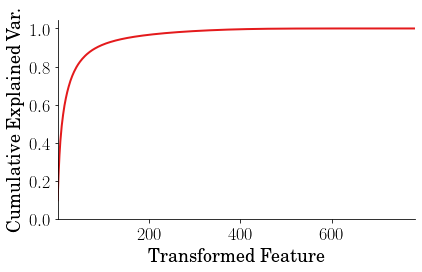

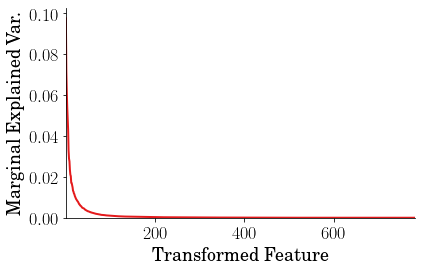

In [9]:

# responses = np.vstack((raw_fft.real,raw_fft.imag,(raw_fft * raw_fft.conj()).real))
responses = np.vstack((cumulative_variance))
plotting.generate_plot(np.arange(cumulative_variance.shape[0]),responses,
                         [''],'Transformed Feature','Cumulative Explained Var.',showplot=True,
                         template='publication',
                         ymax=0.05,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='figures/',
                         filename='Cumulative_Explained_Variance',
                         file_type='png')

responses = np.vstack((pca.explained_variance_ratio_))
plotting.generate_plot(np.arange(cumulative_variance.shape[0]),responses,
                         [''],'Transformed Feature','Marginal Explained Var.',showplot=True,
                         template='publication',
                         ymax=0.05,
                         save_plot=True,
                         transparent=True,
                         num_col=2,
                         folder='figures/',
                         filename='Marginal_Explained_Variance',
                         file_type='png')



In [10]:
pca = PCA(n_components = 30)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

In [11]:
import matplotlib as mpl

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

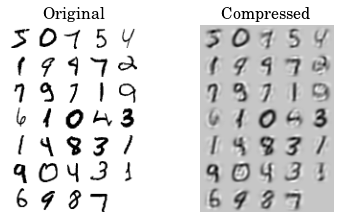

In [12]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("figures/PCA_Compression.png")

In [13]:
np.amin(X_test)

0.0

In [16]:
X_test = X_test.reshape(X_test.shape[0],28,28)
X_train = X_train.reshape(X_train.shape[0],28,28)

X_test = X_test.astype(np.float32) / 255
X_train = X_train.astype(np.float32) / 255

In [17]:
np.amax(X_test)

1.0

In [18]:
param_dict = {
    "hidden_nodes":[100,30],
    "input_shape":[28,28],
}
max_epochs = 10
batch_size = 64
verbose = 0

model,encoder,decoder = create_vanilla_ae(param_dict)

model.compile(loss='binary_crossentropy', 
              optimizer='adam')

loss = model.fit(
            X_train,X_train,
            validation_data=(X_test,X_test),
            epochs=max_epochs,
            batch_size=batch_size,
            verbose=verbose)

X_reconstructed_vanilla_ae = model.predict(X.reshape(X.shape[0],28,28))


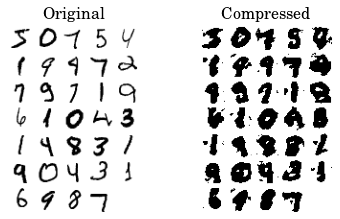

In [19]:
X_reconstructed_vanilla_ae = X_reconstructed_vanilla_ae.reshape(X_reconstructed_vanilla_ae.shape[0],784)
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_reconstructed_vanilla_ae[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("figures/Vanilla_AE_Compression.png")

In [20]:
print(encoder.summary())
print(decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               79184     
_________________________

In [96]:
import numpy as np

import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, UpSampling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model

from ML_Train.Custom_Layers import Dropout_Live

def create_encoder(
                   filters, 
                   kernels, 
                   strides,
                   dilation_rates,
                   input_shape
                   ):
    
    encoder = Sequential()
    encoder.add(Reshape([input_shape[0], input_shape[1], 1], input_shape=input_shape))
    
    for i in range(len(filters)):
        if i == 0:
            encoder.add(Conv2D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='selu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
        else:
            encoder.add(Conv2D(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=strides[i], 
                               activation='selu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
        encoder.add(BatchNormalization())
        encoder.add(Dropout(0.5))
        encoder.add(MaxPooling2D(2))
        
    return encoder

def create_decoder(
                   filters,
                   kernels,
                   strides,
                   dilation_rates,
                   ):
    
    decoder = Sequential()
    
    filters.reverse()
    kernels.reverse()
    strides.reverse()
    dilation_rates.reverse()


    for i in range(1,len(filters)):
        if i == 1:
            decoder.add(Conv2DTranspose(filters=filters[i], 
                   kernel_size=kernels[i], 
                   strides=2, 
                   activation='selu', 
                   padding='valid',
                   dilation_rate=dilation_rates[i],
                   input_shape=[kernels[0],kernels[0],filters[0]]))
        else:
            decoder.add(Conv2DTranspose(filters=filters[i], 
                               kernel_size=kernels[i], 
                               strides=2, 
                               activation='selu', 
                               padding='same',
                               dilation_rate=dilation_rates[i]))
#         decoder.add(Dropout(0.5))
#         decoder.add(UpSampling2D(2))
    
    #decoder.add(Dropout_Live(0.5))
    decoder.add(Conv2DTranspose(1, 3, 2, activation='sigmoid', padding='same'))
    
    return decoder
    
def create_autoencoder(param_dict):
    filters = param_dict["filters"]
    kernels = param_dict["kernels"]
    strides = param_dict["strides"]
    dilation_rates = param_dict["dilation_rates"]
    input_shape = tuple(param_dict["input_shape"])
        
    encoder = create_encoder(filters,kernels,strides,dilation_rates,input_shape)
    decoder = create_decoder(filters,kernels,strides,dilation_rates)
    
    stacked_ae = Sequential([encoder, decoder])

    return stacked_ae,encoder,decoder
    
        

In [98]:
filters= [16,32,64]
kernels = [3,3,3]
strides=[1,1,1]
dilation_rates=[1,1,1]
input_shape = [28,28]

param_dict = {
    "filters":filters,
    "kernels":kernels,
    "strides":strides,
    "dilation_rates":dilation_rates,
    "input_shape":input_shape,
}

model,encoder,decoder = create_autoencoder(param_dict)

In [99]:
list(encoder.output.shape[1:])

[3, 3, 64]

In [100]:
print(encoder.summary())
print(decoder.summary())

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
dropout_6 (Dropout)          (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 14, 14, 32)      

In [101]:
# model.compile(loss='binary_crossentropy', 
#               optimizer='adam')

# loss = model.fit(
#             X_train,X_train,
#             validation_data=(X_test,X_test),
#             epochs=max_epochs,
#             batch_size=batch_size,
#             verbose=1)
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = model.fit(X_train,X_train, epochs=5,batch_size=32,
                      validation_data=(X_test,X_test))

# X_reconstructed_vanilla_ae = model.predict(X.reshape(X.shape[0],28,28))


Train on 56000 samples, validate on 14000 samples
Epoch 1/5
56000/56000 [==============================] - 7s 128us/sample - loss: 0.1409 - rounded_accuracy: 0.9403 - val_loss: 0.1269 - val_rounded_accuracy: 0.9477
Epoch 2/5
56000/56000 [==============================] - 7s 118us/sample - loss: 0.1207 - rounded_accuracy: 0.9524 - val_loss: 0.1179 - val_rounded_accuracy: 0.9539
Epoch 3/5
56000/56000 [==============================] - 7s 117us/sample - loss: 0.1160 - rounded_accuracy: 0.9553 - val_loss: 0.1144 - val_rounded_accuracy: 0.9561
Epoch 4/5
56000/56000 [==============================] - 7s 117us/sample - loss: 0.1134 - rounded_accuracy: 0.9569 - val_loss: 0.1106 - val_rounded_accuracy: 0.9587
Epoch 5/5
56000/56000 [==============================] - 7s 118us/sample - loss: 0.1118 - rounded_accuracy: 0.9579 - val_loss: 0.1089 - val_rounded_accuracy: 0.9596


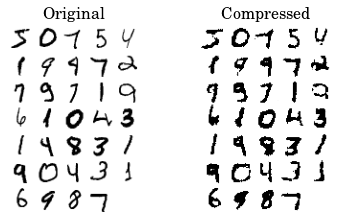

In [102]:
X_reconstructed_vanilla_ae = model.predict(X.reshape(X.shape[0],28,28))
X_reconstructed_vanilla_ae = X_reconstructed_vanilla_ae.reshape(X_reconstructed_vanilla_ae.shape[0],784)
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_reconstructed_vanilla_ae[::2100])
plt.title("Compressed", fontsize=16)

plt.savefig("figures/CNN_AE_Compression.png")